In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [2]:

train_path = "/Users/sandundesilva/Documents/4th year/Research Project/UI/findMyFilm/flask-server/Models/final/GenreDataset/Final_movie_train.csv"
train_data = pd.read_csv(train_path, names=['id', 'name', 'genre', 'subtitles'])

print(train_data.head())


   id                              name     genre  \
0  id                              name     genre   
1   1      Oscar et la dame rose (2009)     drama   
2   2                      Cupid (1997)  thriller   
3   3  Young, Wild and Wonderful (1980)     adult   
4   4             The Secret Sin (1915)     drama   

                                           subtitles  
0                                          subtitles  
1  Listening in to a conversation between his doc...  
2  A brother and sister with a past incestuous re...  
3  As the bus empties the students for their fiel...  
4  To help their unemployed father make ends meet...  


In [3]:
print(train_data.describe())

          id  name   genre                                          subtitles
count   9526  9526    9526                                               9526
unique  9526  9526      28                                               9507
top       id  name  sci-fi  Grammy - music award of the American academy o...
freq       1     1     400                                                  6


In [4]:
print(train_data.isnull().sum())

id           0
name         0
genre        0
subtitles    0
dtype: int64


In [5]:
test_path = "/Users/sandundesilva/Documents/4th year/Research Project/UI/findMyFilm/flask-server/Models/final/GenreDataset/Final_movie_test.csv"
test_data = pd.read_csv(test_path, names=['id', 'name', 'genre', 'subtitles'])

print(test_data.head())


   id                         name        genre  \
0  id                         name        genre   
1   1         Edgar's Lunch (1998)     thriller   
2   2     La guerra de papá (1977)       comedy   
3   3  Off the Beaten Track (2010)  documentary   
4   4       Meu Amigo Hindu (2015)        drama   

                                           subtitles  
0                                          subtitles  
1  L.R. Brane loves his life - his car, his apart...  
2  Spain, March 1964: Quico is a very naughty chi...  
3  One year in the life of Albin and his family o...  
4  His father has died, he hasn't spoken with his...  


/var/folders/3f/yx8qdww526b90tcbqc4y3jjh0000gn/T/ipykernel_88977/3182905106.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, y='genre', order=train_data['genre'].value_counts().index, palette='viridis')
/var/folders/3f/yx8qdww526b90tcbqc4y3jjh0000gn/T/ipykernel_88977/3182905106.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette='viridis')


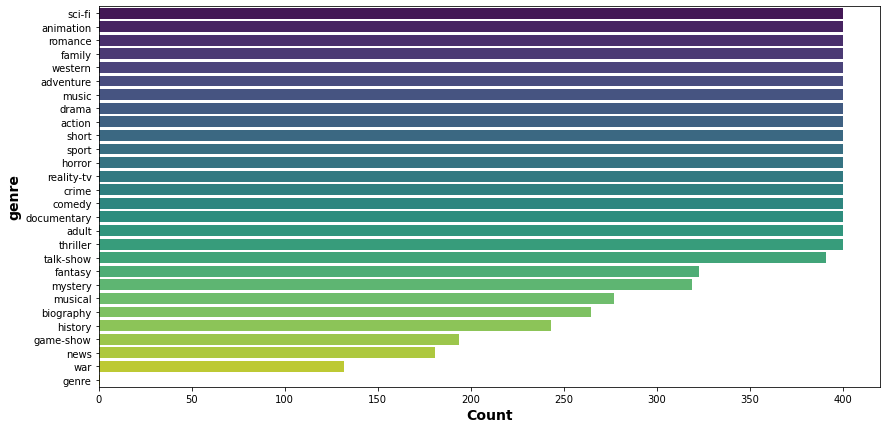

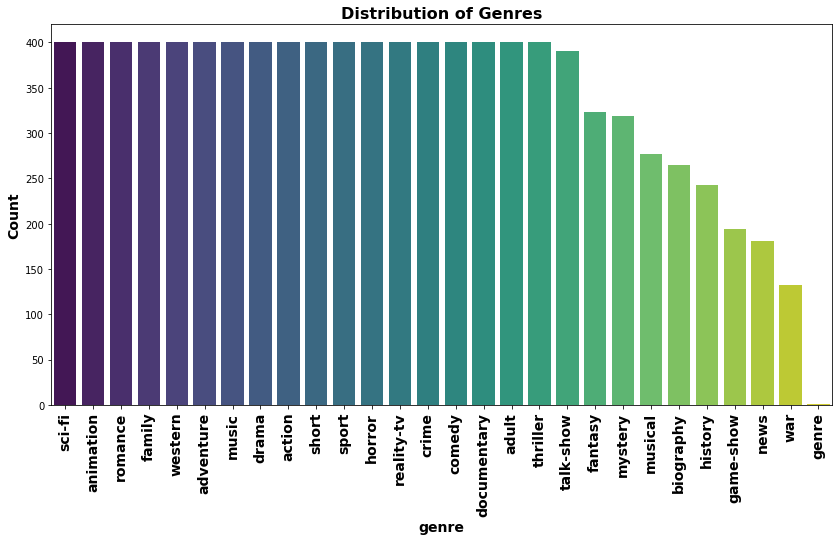

In [6]:
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='genre', order=train_data['genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('genre', fontsize=14, fontweight='bold')

plt.figure(figsize=(14, 7))
counts = train_data['genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis')
plt.xlabel('genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

In [7]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()
    return text  

train_data['Text_cleaning'] = train_data['subtitles'].apply(clean_text)
test_data['Text_cleaning'] = test_data['subtitles'].apply(clean_text)

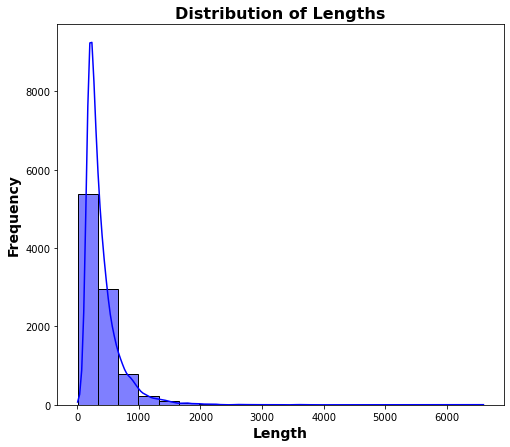

count    9526.000000
mean      397.255616
std       292.308214
min         9.000000
25%       217.000000
50%       305.000000
75%       474.000000
max      6593.000000
Name: length_Text_cleaning, dtype: float64
0                                            subtitles
1    listening conversation doctor parents year old...
2    brother sister past incestuous relationship cu...
3    bus empties students field trip museum natural...
4    help unemployed father make ends meet edith tw...
Name: Text_cleaning, dtype: object


In [8]:
train_data = train_data.dropna(subset=['Text_cleaning'])

train_data['Text_cleaning'].fillna('', inplace=True)

train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)

plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()
print(train_data['length_Text_cleaning'].describe())
print(train_data['Text_cleaning'].head())



In [9]:
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [10]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

print("Number of hidden layers:", len(mlp_classifier.hidden_layer_sizes))
print("Neurons in each hidden layer:", mlp_classifier.hidden_layer_sizes)


Number of hidden layers: 2
Neurons in each hidden layer: (100, 50)


In [11]:
X = X_train
y = train_data['genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1, random_state=42)

In [19]:
y_pred_mlp = mlp_classifier.predict(X_train)
accuracy_mlp = accuracy_score(y_train, y_pred_mlp)
print("Neural Network Training Accuracy:", accuracy_mlp)
print(classification_report(y_train, y_pred_mlp))

Neural Network Training Accuracy: 0.27034120734908135
              precision    recall  f1-score   support

      action       0.00      0.00      0.00       311
       adult       0.98      0.14      0.24       302
   adventure       0.39      0.84      0.54       326
   animation       0.00      0.00      0.00       320
   biography       0.00      0.00      0.00       202
      comedy       0.00      0.00      0.00       318
       crime       0.00      0.00      0.00       315
 documentary       0.48      0.67      0.56       309
       drama       0.00      0.00      0.00       325
      family       0.87      0.23      0.37       311
     fantasy       0.00      0.00      0.00       261
   game-show       0.00      0.00      0.00       158
     history       0.00      0.00      0.00       195
      horror       0.88      0.30      0.45       318
       music       0.16      0.99      0.27       337
     musical       0.00      0.00      0.00       224
     mystery       0.00    

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

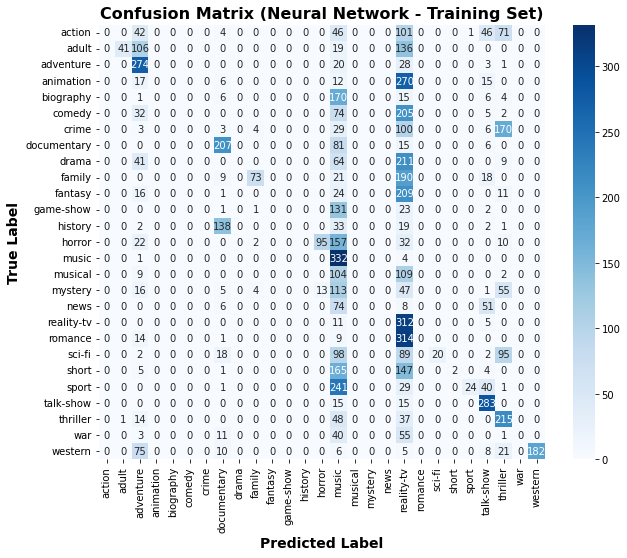

In [20]:
from sklearn.metrics import confusion_matrix

conf_matrix_mlp_train = confusion_matrix(y_train, y_pred_mlp)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mlp_train, annot=True, fmt='d', cmap='Blues', xticklabels=mlp_classifier.classes_, yticklabels=mlp_classifier.classes_)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix (Neural Network - Training Set)', fontsize=16, fontweight='bold')
plt.show()


In [19]:
import joblib
joblib.dump(mlp_classifier, 'neural_network_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("Models saved Successfully.")

Models saved Successfully.


In [21]:
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import numpy as np

loaded_nb_classifier = joblib.load('naive_bayes_model.pkl')
loaded_mlp_classifier = joblib.load('neural_network_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'@\S+', '', text)  
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text) 
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  
    return text

def predict_genre(input_sentence):
    
    cleaned_sentence = preprocess_text(input_sentence)
    
  
    X_input = tfidf_vectorizer.transform([cleaned_sentence])
    

    nb_probabilities = loaded_nb_classifier.predict_proba(X_input)[0]
    mlp_probabilities = loaded_mlp_classifier.predict_proba(X_input)[0]
    

    nb_prediction = np.argmax(nb_probabilities)
    mlp_prediction = np.argmax(mlp_probabilities)
    

    nb_confidence = np.max(nb_probabilities)
    mlp_confidence = np.max(mlp_probabilities)
    
    return nb_prediction, mlp_prediction, nb_confidence, mlp_confidence

input_sentence = input("Enter the text!")
nb_prediction, mlp_prediction, nb_confidence, mlp_confidence = predict_genre(input_sentence)

genre_labels = loaded_nb_classifier.classes_

nb_genre_prediction = genre_labels[nb_prediction]
mlp_genre_prediction = genre_labels[mlp_prediction]

print("Naive Bayes Prediction:", nb_genre_prediction)
print("Naive Bayes Confidence:", nb_confidence)
print("Neural Network Prediction:", mlp_genre_prediction)
print("Neural Network Confidence:", mlp_confidence)



Naive Bayes Prediction: romance
Naive Bayes Confidence: 0.2845427659144829
Neural Network Prediction: romance
Neural Network Confidence: 0.9990815583306517
